# Proyecto Final - Text Mining 2021
Garagiola Nazareno


In [ ]:
!python -m spacy download es_core_news_md

In [1]:
import tweepy
import spacy
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

In [2]:
#f = open('tweets.txt', 'r')
f = open('corpus.txt', 'r')
text = f.read()
text = text.split('\n')
corpus = list(set(text))
f.close()
len(corpus)

15876

In [3]:
f  = open('stopwords.txt','r')
es_stop = f.read().split('\n')
f.close()

---
## Leer archivo

### TO DO

Buscar FastText para usar embeddings, en este caso las features se pasan "directo"

1. Fix features: sacar las palabras, el CV me va a buscar las similaridades este una palabra rara o no
1. Hacer clustering: diferentes cantidad de clusters, revisar que clusters sirven y cuales no
1. KNN en clusters: buscar modelos de las diferentes clases que vea dentro de cada cluster que sea util 




In [4]:
good_val = "top,gusta,buena,entretenida,zarpada,recomiendo,sarpada,buenisima,verla,tremenda,locura,buenarda,encanto,encanta".split(',')
bad_val = "horrendo,infumable,absurdo,absurda,mierda,mal,malo,malisimo,pesimo,pesima,chota,triste,horrible,mala,malita,fea,malisima,sobrevalorado,sobrevalorada,bosta,poronga".split(',')

## Procesamiento

In [5]:
import spacy
nlp = spacy.load("es_core_news_md")

In [19]:
words = list()
for tw in corpus:
    for w in tw.split(' '):
        words.append(w.lower())

counter = Counter(words)

In [20]:
counter

Counter({'': 6099,
         'el': 11795,
         'juego': 15045,
         'del': 20028,
         'calamar': 8631,
         '“acevichado”:': 1,
         'endeudamiento': 3,
         'familiar': 3,
         'como': 1496,
         'bomba': 3,
         'de': 13918,
         'tiempo': 61,
         'en': 5798,
         'corea': 107,
         'sur': 50,
         'y': 5411,
         'peru': 11,
         '|': 355,
         'te': 634,
         'lo': 1735,
         'cuento': 5,
         'facil': 28,
         'blogs': 1,
         'https://t.co/f7zvfypler': 1,
         '#educacion': 3,
         '#economia': 9,
         '#series': 16,
         'https://t.co/qaqpzyu8gr': 1,
         'se': 2976,
         'proclama': 1,
         'disfraz': 544,
         'que': 8953,
         'mas': 1147,
         'exito': 174,
         'tendra': 22,
         'este': 566,
         'halloween.': 43,
         'tambien': 167,
         'los': 3649,
         'personajes': 191,
         'la': 8134,
         'casa': 462,
    



---



In [9]:
def test1(word):
    if word.lower() in good_val:
        return "good"
    elif word.lower() in bad_val:
        return "bad"
    else: return 'neutral' #usar None?

def test(lw):
    valoration = list(map(lambda w: test1(w), lw))
    values = Counter(valoration)
    if values['good'] > values['bad']: return 'good'
    elif values['good'] < values['bad']: return 'bad'
    else: return 'neutral'



---



In [74]:
def filter_token(token):
    return len(token.text) < 2 or token.is_punct or token.like_url or token.is_space or token.text[0]=='@'

def convert_listwords(list_words):
    text = ""
    for word in list_words:
        text = text + " " + word
    return text

def minimum(tweet, p = 0.15):
    #a mayor p, mas chances hay de que los tweets pasen
    sum = 0
    n = len(tweet.split(' '))
    for word in tweet.split(' '):
        if counter[word.lower()] < 5: sum += 1
    return (sum/n > p)


def clean_tweets(corpus=corpus):
    data = {}
    for position, tweet in enumerate(corpus):
        #if minimum(tweet): continue
        doc = nlp(tweet)
        list_words = []
        for token in doc:
            if filter_token(token): continue
            list_words.append(token.text.lower())
        
        data[position] = {"text": convert_listwords(list_words), "val": ''}
    return data


In [77]:
data = clean_tweets(corpus)
clean = [entry["text"] for entry in data.values()]
#val = [entry["val"] for entry in data.values()]

---
## Algoritmos

In [78]:
from sklearn.feature_extraction.text import CountVectorizer

def vectorize(data):
    # filtro de palabras por frecuencia
    vectorizer = CountVectorizer(ngram_range=(1,1), stop_words=es_stop, min_df=10) # probar (1,2)
    matrix = vectorizer.fit_transform(data)
    return matrix

from sklearn.preprocessing import normalize
from sklearn.feature_selection import VarianceThreshold

VARIANCE_THRESHOLD = 1e-5
def transform(matrix):
    selector = VarianceThreshold(threshold=VARIANCE_THRESHOLD)
    normed_matrix = normalize(matrix, axis=1, norm='l1')
    reduced_matrix = selector.fit_transform(normed_matrix)
    print(f"Tamaño original: {normed_matrix.shape}. Tamaño reducido: {reduced_matrix.shape}")
    return normed_matrix, reduced_matrix

In [79]:
#corpus_X = vectorize(corpus)
clean_X = vectorize(clean)

normed_X, transformed_X = transform(clean_X)

Tamaño original: (15876, 1847). Tamaño reducido: (15876, 1770)


In [80]:
for pos, key in enumerate(list(data.keys())):
    #print(key, pos)
    data[key]['vector'] = clean_X[pos]

In [81]:
from sklearn.cluster import KMeans

def sklearn_clustering(k, matrix):
    ## Usar euclidea!
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(X=matrix)
    return clusterer.labels_

from sklearn.neighbors import KNeighborsClassifier

def sklearn_KNN(X,y):
    #aca no es tan sencillo, tengo que tagear manualmente algunos tweets y que esto empieze solo a funcionar y a iterar.
    classifier = KNeighborsClassifier(n_neighbors=3, p=2) #p=2 euclidean
    classifier.fit(X,y)
    return classifier

from sklearn.manifold import TSNE

def tsne_reduction(matrix):
    tsne = TSNE(n_components=2, random_state=0)
    tsne_data = tsne.fit_transform(matrix)
    return tsne_data

from sklearn.decomposition import TruncatedSVD

def lsa_reduction(n_comp, matrix):
    svd = TruncatedSVD(n_components=n_comp)
    lsa_data = svd.fit_transform(X=matrix)
    return lsa_data

In [ ]:
keys_g, keys_b, keys_n = [202,1190,1291,1934,1944,1715],[172,622,984,1209,1923,1732],[190,995,1886,1942,1693,1590]

X_train = np.empty(0)
y_train = np.empty(0)
for k in keys_g:
    X_train = np.append(X_train, data[k]['vector'])
    y_train = np.append(y_train, 'good')
    #X_train.append(data[k]['vector'])
    #y_train.append('good')
for k in keys_b:
    X_train = np.append(X_train, data[k]['vector'])
    y_train = np.append(y_train, 'bad')
    #X_train.append(data[k]['vector'])
    #y_train.append('bad')
for k in keys_n:
    X_train = np.append(X_train, data[k]['vector'])
    y_train = np.append(y_train, 'neutral')
    #X_train.append(data[k]['vector'])
    #y_train.append('neutral')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=2, p=2)
classifier.fit(X_train.reshape(-1,1), y_train)

In [82]:
NUM_CLUSTERS = 10

clean_sk_cluster =  sklearn_clustering(NUM_CLUSTERS, transformed_X)
clean_tsne_data = tsne_reduction(transformed_X)

In [83]:

row = [(clean_tsne_data[i], clean_sk_cluster[i], clean[i]) for i in range(len(clean))]
clean_df = pd.DataFrame(
    data=[(coords[0], coords[1], cluster, word) for coords, cluster, word in row],
    columns=["dim1", "dim2", "cluster", "tweet"]
)


In [84]:
clean_df.head(5)

,dim1,dim2,cluster,tweet
0,22.865175,-7.689716,1,
1,21.514839,-31.314856,0,el juego del calamar acevichado el endeudamie...
2,46.344841,37.796280,9,el juego del calamar se proclama como el disf...
3,-4.329869,-25.830620,3,el juego del calamar esta re quemado varios p...
4,2.529772,-56.905121,9,111 millones de personas vieron el juego del ...


In [103]:
def plot_all(df):
    plt.figure(figsize=(22, 8))
    g = plt.scatter(x=df['dim1'],y=df['dim2'], s=10, c=df['cluster'], cmap='Dark2', alpha=1)
    plt.colorbar(g)
#for i in range(len(corpus)):
#    plt.annotate(df['cluster'][i], (df['dim1'][i], df['dim2'][i]))
    plt.show()

def show_cluster(df, n):
    msgs = list(df[df['cluster']==n]['tweet'])
    for msg in msgs:
        text = msg
        print(text)

from random import randint
def show_sample(df):
    for i in range(NUM_CLUSTERS):
        u = randint(0,NUM_CLUSTERS)
        msg = list(df[df['cluster']==i]['tweet'])[u]
        print(f"Cluster {i}. Sample: {msg}")

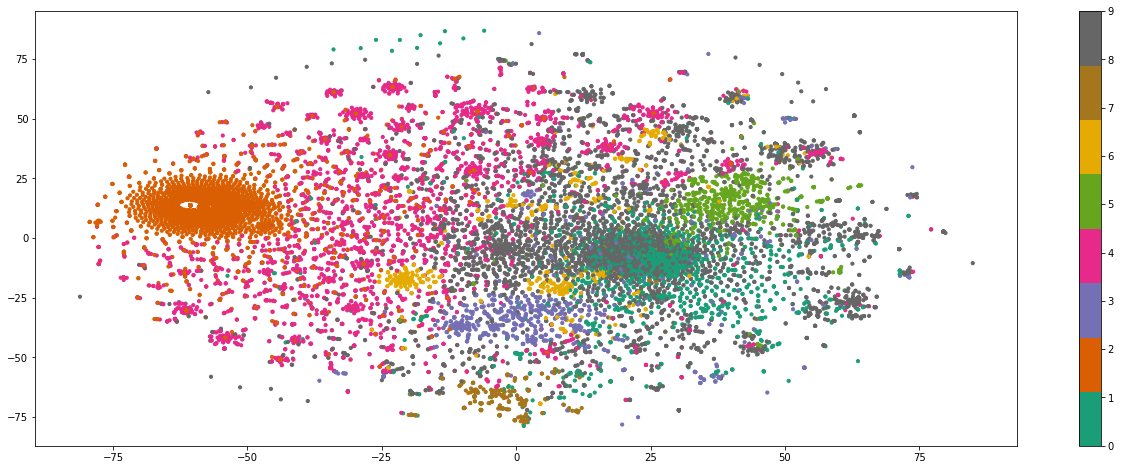

In [96]:
plot_all(clean_df)

In [104]:
show_sample(clean_df)

Cluster 0. Sample:  yo siempre llego tarde las series de moda pero que mierda es esa del juego del calamar como hacer para que se acabe esto
Cluster 1. Sample:  sali dar una vuelta un monton de gente con asados de jaloguin pendejo disfrazados del juego del calamar pero habia un cabro chico con un autito rojo disfrazado de mario otro nivel
Cluster 2. Sample:  como todo dorama el juego del calamar tampoco descepciona
Cluster 3. Sample:  mis padres estan acaban de empezar el juego del calamar mis padres una serie asiatica increible
Cluster 4. Sample:  con la polemica del juego del calamar se ha conseguido el efecto contrario
Cluster 5. Sample:  al imitar uno de los desafios de el juego del calamar ninos resultan con quemaduras graves en australia
Cluster 6. Sample:  no quiero ver el juego del calamar ya se de que va es mas tengo la sensacion de que nos lo estan aplicando los espanoles
Cluster 7. Sample:  criptomoneda de el juego del calamar resulto siendo una estafa
Cluster 8. Sample:  es

---

In [106]:
show_cluster(clean_df, 8)

 yo fingiendo que no quiero dibujar yong como en el juego del calamar aunque es obvio que quiero para halloween
 hola guapa de lo de disfraces de halloween pues parece que lo de este ano sera moda lo del juego del calamar pero eso no es sexy creo que tal algo asi de la pricesa de mario bros
 cuantos desquiciados aprovecharan este halloween el tiron del juego del calamar para disfrazarse salir con armas de verdad liarla parda
 halloween tragico en panama recrearon el juego del calamar la fiesta termino en un sanguinario enfrentamiento de pandillas noticias
 los artistas venezolanos sus disfraces de halloween de senora de la harina hasta el juego del calamar foto
 hay que ser del monton para disfrazarse del juego del calamar para halloween
 este halloween vi mucho disfraz de cruella de vil el juego del calamar
 por favor la fiebre del juego del calamar es horrible saturacion de disfraces de halloween que mas bien se asemeja al uniforme de un repostador de cepsa
 escuelas en nueva york pr